# Getting started with Approximate quantum compilation with tensor networks (AQC-Tensor)

This guide demonstrates a simple working example to get started with AQC-Tensor. In this example, you will take a Trotter circuit which simulates the evolution of a transverse field Ising model and use the AQC-Tensor method to reduce the resulting circuit depth. In addition, this example requires the `qiskit-addon-utils` package for the problem generator, `qiskit-aer` for the tensor-network simulation, and `scipy` for the parameter optimization.

To begin, recall that the Hamiltonian of the transverse field Ising model has the form

$$ \mathcal{H}_{Ising} = \sum_{i=1}^N J_{i,(i+1)}Z_iZ_{i+1} + h_i X_i $$

where we'll assume periodic boundary conditions which imply that for $i=10$ we obtain $i+1=11\rightarrow 1$ and $J$ is the coupling strength between two sites and $h$ is the strength of the external magnetic field.

The following code snippet will generate the Hamiltonian of a 10-site Ising chain with periodic boundary conditions.

In [1]:
from qiskit.transpiler import CouplingMap
from qiskit_addon_utils.problem_generators import generate_xyz_hamiltonian
from qiskit.synthesis import SuzukiTrotter
from qiskit_addon_utils.problem_generators import (
    generate_time_evolution_circuit,
)
from qiskit_addon_aqc_tensor import generate_ansatz_from_circuit
from qiskit_addon_aqc_tensor.simulation import tensornetwork_from_circuit
from qiskit_addon_aqc_tensor.simulation import compute_overlap
from qiskit_addon_aqc_tensor.objective import MaximizeStateFidelity
from qiskit_aer import AerSimulator
from scipy.optimize import OptimizeResult, minimize


# Generate some coupling map to use for this example
coupling_map = CouplingMap.from_heavy_hex(3, bidirectional=False)

# Choose a 10-qubit circle on this coupling map
reduced_coupling_map = coupling_map.reduce(
    [0, 13, 1, 14, 10, 16, 4, 15, 3, 9]
)

# Get a qubit operator describing the Ising field model
hamiltonian = generate_xyz_hamiltonian(
    reduced_coupling_map,
    coupling_constants=(0.0, 0.0, 1.0),
    ext_magnetic_field=(0.4, 0.0, 0.0),
)

## Split the time evolution into two pieces for classical and quantum execution

The overall goal of this example is to simulate time evolution of the model Hamiltonian. We do so here by Trotter evolution, which will be split into two portions.

1. An initial portion which is simulable using matrix product states (MPS). This will be what is 'compiled' using AQC-Tensor.
2. A subsequent portion which will be executed on quantum hardware.

We'll choose to evolve the system up to time $t_f=5$ and use AQC-Tensor to compress the time evolution up to time $t=4$, then evolve using ordinary Trotter steps up to time $t_f$.

From here we will next generate two circuits, one which will be compressed using AQC-Tensor and one which will be executed on a QPU. For the first circuit, since this will be simulated classically using matrix product states, we will use a generous number of layers to minimize Trotter error. Meanwhile the second circuit simulating time evolution from $t_i=4$ to $t_f=5$ will use much fewer layers in order to minimize depth.

In [2]:
# Generate circuit to be compressed
aqc_evolution_time = 4.0
aqc_target_num_trotter_steps = 45

aqc_target_circuit = generate_time_evolution_circuit(
    hamiltonian,
    synthesis=SuzukiTrotter(reps=aqc_target_num_trotter_steps),
    time=aqc_evolution_time,
)

# Generate circuit to execute on hardware
subsequent_evolution_time = 1.0
subsequent_num_trotter_steps = 5

subsequent_circuit = generate_time_evolution_circuit(
    hamiltonian,
    synthesis=SuzukiTrotter(reps=subsequent_num_trotter_steps),
    time=subsequent_evolution_time,
)

For comparison purposes, we will also generate a third circuit. One which evolves until $t=4$, but which has the same number of layers as the second circuit evolving from $t_i=4$ to $t_f=5$. This is the circuit we *would have* executed has we not used the AQC-Tensor technique. We'll call this the *comparison* circuit for now.

In [3]:
aqc_comparison_num_trotter_steps = int(
    subsequent_num_trotter_steps
    / subsequent_evolution_time
    * aqc_evolution_time
)
aqc_comparison_num_trotter_steps

comparison_circuit = generate_time_evolution_circuit(
    hamiltonian,
    synthesis=SuzukiTrotter(reps=aqc_comparison_num_trotter_steps),
    time=aqc_evolution_time,
)

## Generate ansatz and construct MPS simulation

Next we will generate the ansatz we will optimize. It will evolve to the same evolution time as our first circuit (from $t_i=0$ to $t_f=4$), but with fewer Trotter steps.

Once the circuit has been generated, we then pass it to AQC-Tensor's `generate_ansatz_from_circuit()` function which analyzes the two-qubit connectivity and returns two things. First is a generated ansatz circuit with the same two-qubit connectivity, and the second is a set of parameters which, when plugged into the ansatz, yield the input circuit.

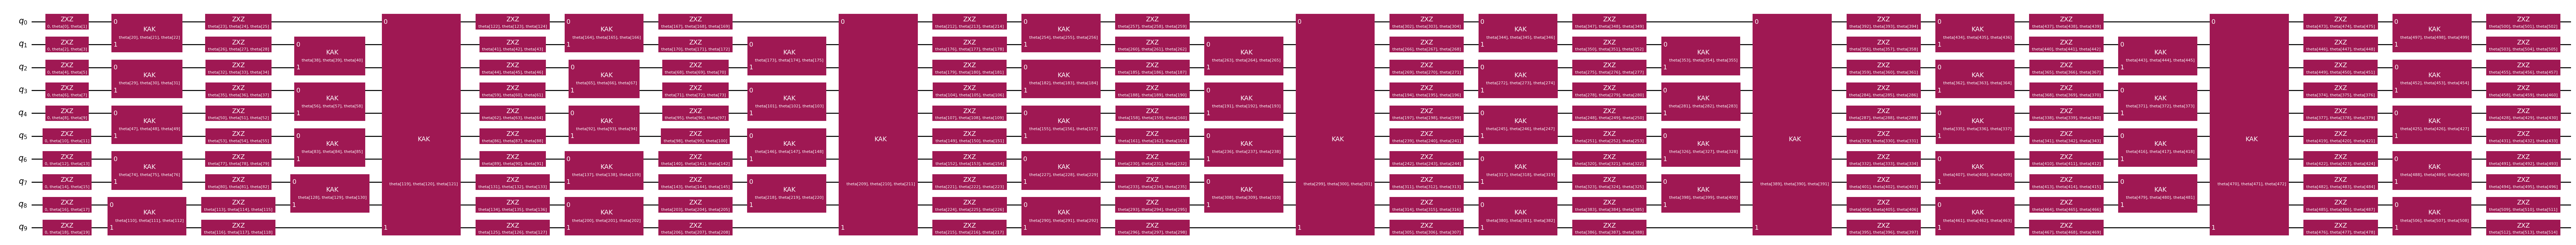

In [4]:
aqc_ansatz_num_trotter_steps = 5

aqc_good_circuit = generate_time_evolution_circuit(
    hamiltonian,
    synthesis=SuzukiTrotter(reps=aqc_ansatz_num_trotter_steps),
    time=aqc_evolution_time,
)

aqc_ansatz, aqc_initial_parameters = generate_ansatz_from_circuit(
    aqc_good_circuit, qubits_initially_zero=True
)
aqc_ansatz.draw("mpl", fold=-1)

Next we will build the MPS representation of the state to be approximated by AQC. We will also calculate the fidelity $|\langle\psi_1 | \psi_2 \rangle |^2$ between the state prepared by the comparison circuit vs the one circuit which generates the target state (which used more Trotter steps).

In [5]:
# Generate MPS simulator settings and obtain the MPS representation of the target state
simulator_settings = AerSimulator(
    method="matrix_product_state",
    matrix_product_state_max_bond_dimension=100,
)
aqc_target_mps = tensornetwork_from_circuit(
    aqc_target_circuit, simulator_settings
)


# Compute the fidelity between the MPS representation of the target state and the state produced by the comparison circuit
comparison_mps = tensornetwork_from_circuit(
    comparison_circuit, simulator_settings
)
comparison_fidelity = (
    abs(compute_overlap(comparison_mps, aqc_target_mps)) ** 2
)
print(f"Comparison fidelity: {comparison_fidelity}")

Comparison fidelity: 0.9997111919737661


## Optimize the parameters of the ansatz using the MPS

Lastly, we will optimize the ansatz circuit such that it produces the target state better than our `comparison_fidelity`. The cost function to minimize will be the `MaximizeStateFidelity` and will be optimized using scipy's L-BFGS optimizer.

In [7]:
objective = MaximizeStateFidelity(
    aqc_target_mps, aqc_ansatz, simulator_settings
)

stopping_point = 1 - comparison_fidelity


def callback(intermediate_result: OptimizeResult):
    print(f"Intermediate result: Fidelity {1 - intermediate_result.fun:.8}")
    if intermediate_result.fun < stopping_point:
        # Good enough for now
        raise StopIteration


result = minimize(
    objective,
    aqc_initial_parameters,
    method="L-BFGS-B",
    jac=True,
    options={"maxiter": 100},
    callback=callback,
)
if (
    result.status
    not in (
        0,
        1,
        99,
    )
):  # 0 => success; 1 => max iterations reached; 99 => early termination via StopIteration
    raise RuntimeError(
        f"Optimization failed: {result.message} (status={result.status})"
    )

print(f"Done after {result.nit} iterations.")
aqc_final_parameters = result.x

Intermediate result: Fidelity 0.95084365
Intermediate result: Fidelity 0.98409893
Intermediate result: Fidelity 0.99142033
Intermediate result: Fidelity 0.99521405
Intermediate result: Fidelity 0.99566673
Intermediate result: Fidelity 0.99650054
Intermediate result: Fidelity 0.99683487
Intermediate result: Fidelity 0.99720426
Intermediate result: Fidelity 0.99761726
Intermediate result: Fidelity 0.99809073
Intermediate result: Fidelity 0.99838244
Intermediate result: Fidelity 0.99861841
Intermediate result: Fidelity 0.99874617
Intermediate result: Fidelity 0.99892696
Intermediate result: Fidelity 0.99908129
Intermediate result: Fidelity 0.99917737
Intermediate result: Fidelity 0.99925456
Intermediate result: Fidelity 0.99933134
Intermediate result: Fidelity 0.99947173
Intermediate result: Fidelity 0.99956469
Intermediate result: Fidelity 0.99964488
Intermediate result: Fidelity 0.99967419
Intermediate result: Fidelity 0.99968821
Intermediate result: Fidelity 0.9997448
Done after 24 ite

At this point we have a set of parameters which generate the target state with a higher fidelity than what the comparison circuit would have produced without using AQC. With these optimal parameters, the compressed circuit now has less Trotter error *and* less depth than the original circuit.

As a final step, the following code snippet builds the full time evolution circuit which can be passed to a transpiler pipeline and executed on quantum hardware.

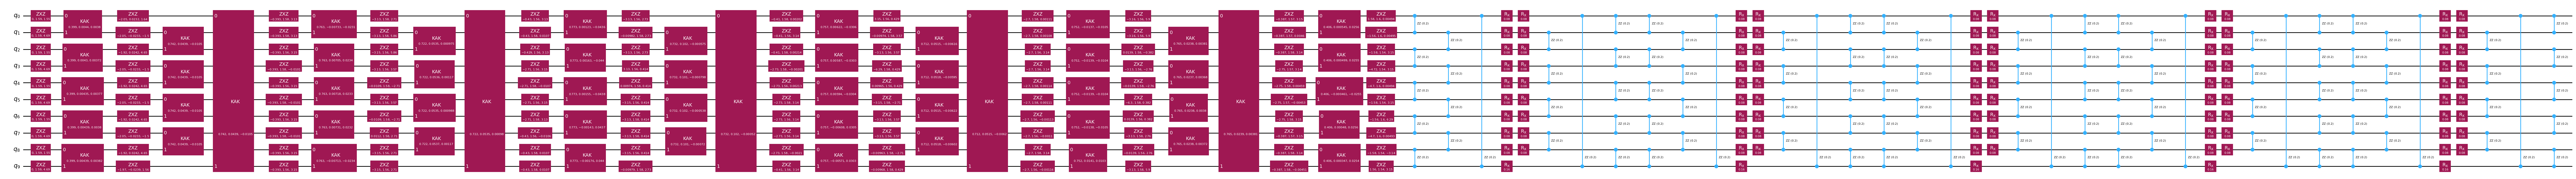

In [8]:
final_circuit = aqc_ansatz.assign_parameters(aqc_final_parameters)
final_circuit.compose(subsequent_circuit, inplace=True)
final_circuit.draw("mpl", fold=-1)

## Next steps

<Admonition type="tip" title="Recommendations">
    - Read through the [AQC-Tensor tutorial](https://learning.quantum.ibm.com/tutorial/improved-trotterized-time-evolution-with-approximate-quantum-compilation)
</Admonition>